In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import Sequential,Model
from keras.layers import concatenate,Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling1D, AveragePooling2D, Input, Add, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import model_from_json
from sklearn.metrics import roc_curve
from keras.utils import np_utils
from tqdm import tqdm
import pandas as pd
import numpy as np
import librosa 
import librosa.display
import pylab
import matplotlib.pyplot as plt
import cv2
import os

2021-09-23 17:16:56.852674: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


---
# 1-Prepare Data
---



In [3]:
names   = ['ID','Fever/MP','ORC','STATUS','DIR','DataSet']
data_dir = '/home/pmp/Workspace/Myoungjin/CoughData/Data'
#join_by = pd.read_csv('/content/Coswara-Data/combined_data.csv')
join_by = pd.read_csv(data_dir+'/Coswara/combined_data.csv')

import glob
df_list = []
for path in tqdm(glob.glob(data_dir+'/Coswara/*/*/*/cough-shallow.wav')):
  temp = pd.DataFrame(columns=['id','DIR'])
  temp['id'] = [path.split('/')[-2]]
  temp['DIR'] = [path]
  temp = pd.merge(left=temp,right=join_by,on='id',how='inner')

  temp['fomp']= (temp['fever']| temp['mp']).apply(int)
  temp['oths']= (temp['cld']|temp['asthma']|temp['cold']|temp['st']|temp['pneumonia']).apply(int)
  temp        = temp[['id','covid_status','DIR','fomp','oths']]
  df_list.append(temp.rename(columns={'id':'ID','covid_status':'STATUS','DIR':'DIR','fomp':'Fever/MP','oths':'ORC'}))
CosData=pd.concat(df_list)
CosData['DataSet'] = 'coswara'
CosData.head()

100%|██████████████████████████████████████| 1489/1489 [00:08<00:00, 165.48it/s]


,ID,STATUS,DIR,Fever/MP,ORC,DataSet
0,40NRJEGpU9Vg2IFXcuqCQLiKLVz1,positive_asymp,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,0,0,coswara
0,kBFDtvAVY9QYbi7YHYgd7tNpsWx1,positive_asymp,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,0,0,coswara
0,Axei3vO2YcQM56PrwqmMF40A6aG3,resp_illness_not_identified,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,0,0,coswara
0,05acPS4aRGfvuOfku11Za8zve8i2,positive_mild,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,0,1,coswara
0,DmKc9V8ZeqQBMqOaGMDZ3mvRIY13,healthy,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,0,0,coswara


## Prepare dataset

+ coswara 와 coughvid concat

In [2]:
names   = ['ID','Fever/MP','ORC','STATUS','DIR','DataSet']
data_dir = '/home/pmp/Workspace/Myoungjin/CoughData/Data'

coughvid  = data_dir+'/COUGHVID/public_dataset_wav/'
custpath  = '/home/pmp/Workspace/Myoungjin/CoughRecognition/virufy-covid-main/cough/custom_dataset/' #Where mel spec images will be stored

VidData   = pd.read_csv(os.path.join(data_dir+'/COUGHVID/','metadata_compiled.csv'),header=0)
VidData   = VidData.loc[VidData['cough_detected'] >= 0.9][['uuid','fever_muscle_pain','respiratory_condition','status']]
VidData.dropna(inplace=True)

extradata = VidData.loc[VidData['status']=='COVID-19']
notradata = VidData.loc[VidData['status']!='COVID-19'][0:1000]

TotData   = pd.concat([extradata,notradata],ignore_index= True)
#TotData['DIR'] = coughvid + TotData['uuid'] + '.webm'
TotData['DIR'] = coughvid + TotData['uuid'] + '.wav'
TotData['DataSet'] = 'coughvid'
TotData['fever_muscle_pain']    = TotData['fever_muscle_pain'].apply(int)
TotData['respiratory_condition']= TotData['respiratory_condition'].apply(int)
print(len(TotData))
TotData   = pd.concat([CosData,TotData.rename(columns={'uuid':'ID','status':'STATUS','fever_muscle_pain':'Fever/MP','respiratory_condition':'ORC'})])
TotData   = TotData.sample(frac=1).reset_index(drop=True)
TotData.head()

1441


NameError: name 'CosData' is not defined

In [5]:
print(len(TotData))

2930


## Feature Extraction

In [5]:
def feature_extractor(row):

  name     = row[0]
  try:
    audio,sr = librosa.load(row[-4])
    #For MFCCS 
    mfccs    = librosa.feature.mfcc(y=audio,sr=sr, n_mfcc=39)
    mfccsscaled = np.mean(mfccs.T,axis=0)
    
    #Mel Spectogram
    #pylab.axis('off') # no axis
    #pylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[])
    plt.axis('off') # no axis
    plt.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[])
    melspec  = librosa.feature.melspectrogram(y=audio,sr=sr)
    s_db     = librosa.power_to_db(melspec, ref=np.max)
    librosa.display.specshow(s_db)

    savepath = os.path.join(custpath,name+'.png')
    #pylab.savefig(savepath, bbox_inches=None, pad_inches=0)
    #pylab.close()
    plt.savefig(savepath, bbox_inches=None, pad_inches=0)
    plt.close()
  except:
    print('File cannot open')
    return None,None
  return mfccsscaled,savepath

features = []
diagnoses= []
imgpaths = []

In [6]:
for row in tqdm(TotData.values):
  mfccs,savepath  = feature_extractor(row)
  features.append(mfccs)
  imgpaths.append(savepath)
  diagnoses.append([row[3],row[4]])
'''
print(TotData.values[2])
row = TotData.values[2]
name = row[0]
audio,sr = librosa.load(row[-4])
mfccs = librosa.feature.mfcc(y=audio,sr=sr, n_mfcc=39)
mfccsscaled = np.mean(mfccs.T,axis=0)

plt.axis('off')
plt.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[])
melspec  = librosa.feature.melspectrogram(y=audio,sr=sr)
s_db     = librosa.power_to_db(melspec, ref=np.max)
librosa.display.specshow(s_db)
savepath = os.path.join(custpath,name+'.png')
plt.savefig(savepath, bbox_inches=None, pad_inches=0)
'''
#pylab.close()
#print(features)
#print(imgpaths)
#print(diagnoses)



print(len(features))
print(len(imgpaths))
print(len(diagnoses))


  0%|                                          | 5/2930 [00:02<23:23,  2.08it/s]

File cannot open


 17%|██████▋                                 | 494/2930 [03:35<17:53,  2.27it/s]

File cannot open


 23%|█████████                               | 665/2930 [04:48<13:15,  2.85it/s]

File cannot open


 24%|█████████▍                              | 689/2930 [04:57<13:38,  2.74it/s]

File cannot open


 24%|█████████▌                              | 703/2930 [05:03<14:29,  2.56it/s]

File cannot open


 24%|█████████▋                              | 708/2930 [05:05<16:46,  2.21it/s]

File cannot open


 28%|███████████                             | 809/2930 [05:49<14:11,  2.49it/s]

File cannot open


 28%|███████████▏                            | 821/2930 [05:53<15:07,  2.32it/s]

File cannot open


 28%|███████████▎                            | 829/2930 [05:57<14:28,  2.42it/s]

File cannot open


 31%|████████████▏                           | 894/2930 [06:24<13:37,  2.49it/s]

File cannot open


 34%|█████████████▍                          | 984/2930 [07:01<13:25,  2.42it/s]

File cannot open


 37%|██████████████▍                        | 1086/2930 [07:45<09:42,  3.17it/s]

File cannot open


 46%|█████████████████▉                     | 1343/2930 [09:36<09:32,  2.77it/s]

File cannot open


 47%|██████████████████▎                    | 1377/2930 [09:51<13:09,  1.97it/s]

File cannot open


 51%|███████████████████▊                   | 1485/2930 [10:35<10:51,  2.22it/s]

File cannot open


 53%|████████████████████▊                  | 1561/2930 [11:07<08:59,  2.54it/s]

File cannot open


 55%|█████████████████████▌                 | 1618/2930 [11:31<09:51,  2.22it/s]

File cannot open


 68%|██████████████████████████▎            | 1981/2930 [14:08<05:57,  2.65it/s]

File cannot open


 79%|██████████████████████████████▊        | 2314/2930 [16:32<04:37,  2.22it/s]

File cannot open


 81%|███████████████████████████████▍       | 2366/2930 [16:54<03:51,  2.43it/s]

File cannot open


 84%|████████████████████████████████▊      | 2466/2930 [17:36<03:41,  2.09it/s]

File cannot open


 88%|██████████████████████████████████▎    | 2576/2930 [18:24<02:39,  2.22it/s]

File cannot open


 91%|███████████████████████████████████▎   | 2654/2930 [18:58<02:14,  2.05it/s]

File cannot open


 91%|███████████████████████████████████▋   | 2680/2930 [19:11<01:48,  2.30it/s]

File cannot open


 95%|████████████████████████████████████▉  | 2773/2930 [19:51<01:05,  2.41it/s]

File cannot open


 96%|█████████████████████████████████████▌ | 2823/2930 [20:11<00:39,  2.68it/s]

File cannot open


 98%|██████████████████████████████████████ | 2860/2930 [20:25<00:30,  2.31it/s]

File cannot open


 98%|██████████████████████████████████████▎| 2882/2930 [20:35<00:26,  1.79it/s]

File cannot open


100%|███████████████████████████████████████| 2930/2930 [20:55<00:00,  2.33it/s]

2930
2930
2930


In [7]:
print(features)
print(imgpaths)
print(diagnoses)

[array([-3.1761441e+02,  4.0143326e+01, -2.5243172e+01,  1.5525323e+01,
       -4.4481750e+01,  7.5624003e+00, -2.0660534e+01, -1.1366920e+01,
       -1.8914682e+01,  1.6364917e+00, -2.4760468e+00, -9.9044151e+00,
        4.9944967e-01, -8.5866270e+00,  3.2649574e+00, -4.7985220e+00,
        5.1824818e+00, -3.4843044e+00, -1.6182845e+00,  1.8760586e+00,
        5.4510868e-01,  4.2594999e-01, -5.4282103e+00,  1.1128578e-01,
       -5.5432773e-01,  2.9285979e+00, -6.7989987e-01,  1.5994369e+00,
        1.3948725e+00,  2.2021227e+00,  3.2045488e+00, -1.1896031e+00,
       -4.9776950e-01, -6.0639775e-01, -1.3711394e-01,  1.9615558e-01,
       -8.4612942e-01,  6.1444467e-01,  8.1902444e-01], dtype=float32), array([-4.40199493e+02,  5.58080368e+01, -1.05369101e+01,  1.48414040e+01,
       -6.60585117e+00,  2.21303988e+00, -3.58242583e+00, -2.28066087e+00,
       -8.30704117e+00, -6.12621641e+00, -3.09090137e+00, -1.08017337e+00,
        1.70762420e-01, -9.73241520e+00, -2.05963087e+00, -2.99

---
# 2- Data Sampling 
---

## Remove Nans

In [7]:
isnone = lambda x: x is not None
label  = lambda x: 1 if x == 'positive_mild' or x =='positive_moderate' or x == 'COVID-19' else 0
cast_x = list(map(isnone,features))
#cast_x = list(map(features))
data_y = list(map(label,TotData['STATUS']))

data_x = [features[i] for i in range(len(features)) if cast_x[i] == True]
data_xx= [imgpaths[i] for i in range(len(imgpaths)) if cast_x[i] == True]
data_xp= [diagnoses[i]for i in range(len(diagnoses))if cast_x[i] == True]
data_y = [data_y[i] for i in range(len(features)) if cast_x[i] == True]

print(len(data_x))

2902


## Prepare Data Splits
  n = NUM_shuf





In [8]:
assert len(data_x) == len(data_xx) == len(data_xp), "Data lengths do not match"
#print(len(data_x))
indices = np.arange(len(data_x))
NUM_shuf= 5
DATA    = {i:{} for i in range(NUM_shuf)}

for i in range(NUM_shuf):
  np.random.shuffle(indices)

  DATA[i]['MFCCS'] = np.array([data_x[i] for i in indices])
  DATA[i]['MEL']   = [data_xx[i] for i in indices]
  DATA[i]['EXTRA'] = np.array([data_xp[i] for i in indices])
  DATA[i]['LABELS']= np.array([data_y[i] for i in indices])

In [22]:
print(DATA[3])

{'MFCCS': array([[-4.2938120e+02,  2.4863131e+01, -6.8473134e+00, ...,
         1.0005162e+00,  5.5767208e-01, -9.2969137e-01],
       [-3.8456323e+02,  6.1361744e+01, -3.7443602e+00, ...,
         4.1961682e-01, -1.2343801e+00, -6.2502660e-02],
       [-4.3192657e+02,  3.5049725e+01, -6.1106750e+01, ...,
        -3.7353714e+00, -1.9223913e+00, -1.7625502e+00],
       ...,
       [-3.7460571e+02,  5.4073135e+01, -3.6414680e+01, ...,
        -7.9893601e-01,  1.1270833e+00, -8.0685228e-01],
       [-4.7139911e+02,  2.6540785e+01, -1.5377823e+01, ...,
         5.5300727e-02,  3.3392433e-02, -6.7598140e-01],
       [-5.3066986e+02,  2.4017952e+01, -5.5321012e+00, ...,
        -5.1180121e-02, -6.9289130e-01, -2.5681594e-01]], dtype=float32), 'MEL': ['/home/pmp/Workspace/Myoungjin/CoughRecognition/virufy-covid-main/cough/custom_dataset/2b907f26-5522-4b7d-a5e1-60e2277f148b.png', '/home/pmp/Workspace/Myoungjin/CoughRecognition/virufy-covid-main/cough/custom_dataset/YRwYptwqVUfHZbZh1hiqsczaT8m1

In [9]:
# Save extracted features
# Note: mel specs not saved
import pickle
pickle.dump( DATA, open( "loaded_data.pickle", "wb" ) )

## Data Generator




In [2]:
class CustomDataset(tf.keras.utils.Sequence):
  def __init__(self,imgfiles,labels,batch_size,target_size=(64,64),shuffle=False,scale=255,n_classes=1,n_channels=3):
    self.batch_size = batch_size
    self.dim        = target_size
    self.labels     = labels
    self.imgfiles   = imgfiles
    self.n_classes  = n_classes
    self.shuffle    = shuffle
    self.n_channels = n_channels
    self.scale      = scale

    self.c          = 0
    self.on_epoch_end()

  def __len__(self):
    # returns the number of batches
    return int(np.floor(len(self.imgfiles) / self.batch_size))

  def __getitem__(self, index):
    # returns one batch
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

    # Generate data
    X, y = self.__data_generation(indexes)
    return X, y

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.imgfiles))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)
  
  def __data_generation(self, list_IDs_temp):
    X = np.empty((self.batch_size, *self.dim, self.n_channels))
    y = np.empty((self.batch_size), dtype=int)

    # Generate data
    for i, ID in enumerate(list_IDs_temp):
        # Store sample
        img   = cv2.imread(self.imgfiles[ID])
        img   = cv2.resize(img,self.dim,interpolation = cv2.INTER_CUBIC)
        X[i,] = img / self.scale

        # Store class
        y[i] = self.labels[ID]

        self.c +=1
    return X, y #keras.utils.to_categorical(y, num_classes=self.n_classes)


class CustomPipeline(tf.keras.utils.Sequence):
  def __init__(self,data_x,data_y,batch_size=48,shuffle=False,n_classes=1):
    self.features   = data_x
    self.labels     = data_y
    self.batch_size = 48
    self.shuffle    = shuffle
    self.n_features = self.features.shape[1]
    self.n_classes  = 1
    self.on_epoch_end()

  def __len__(self):
    return int(np.floor(len(self.features) / self.batch_size))

  def __getitem__(self,index):
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
    X, y = self.__data_generation(indexes)
    return X, y

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.features))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def __data_generation(self,indexes):
    X = np.empty((self.batch_size, self.n_features))
    y = np.empty((self.batch_size), dtype=int)

    for i, ID in enumerate(indexes):
      X[i,] = self.features[ID]
      y[i,] = self.labels[ID]
    return X, y

class MultipleInputGenerator(tf.keras.utils.Sequence):
  """Wrapper of two generatos for the combined input model"""

  def __init__(self, X1, X2, Y, batch_size,target_size=(64,64)):
      self.genX1 = CustomPipeline(X1, Y, batch_size=batch_size,shuffle=False)
      self.genX2 = CustomDataset (X2, Y, batch_size=batch_size,shuffle=False,target_size=target_size)

  def __len__(self):
      return self.genX1.__len__()

  def __getitem__(self, index):
      X1_batch, Y_batch = self.genX1.__getitem__(index)
      X2_batch, Y_batch = self.genX2.__getitem__(index)
      X_batch = [X1_batch, X2_batch]
      return X_batch, Y_batch

class TripleInputGenerator(tf.keras.utils.Sequence):
  """Wrapper of two generatos for the combined input model"""

  def __init__(self, X1, X2, X3, Y, batch_size,target_size=(64,64)):
      self.genX1 = CustomPipeline(X1, Y, batch_size=batch_size,shuffle=False)
      self.genX2 = CustomDataset (X2, Y, batch_size=batch_size,shuffle=False,target_size=target_size)
      self.genX3 = CustomPipeline(X3, Y, batch_size=batch_size,shuffle=False)
  def __len__(self):
      return self.genX1.__len__()

  def __getitem__(self, index):
      X1_batch, Y_batch = self.genX1.__getitem__(index)
      X2_batch, Y_batch = self.genX2.__getitem__(index)
      X3_batch, Y_batch = self.genX3.__getitem__(index)

      X_batch = [X1_batch, X2_batch, X3_batch]
      return X_batch, Y_batch

---
# 3- Training and Evaluation
---

In [3]:
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback
class Evaluation(keras.callbacks.Callback):
  
  def __init__(self, val_data_gen, val_labels, test_data_gen, test_labels):
    super(Callback, self).__init__()
    self.test_data = test_data_gen
    self.val_labels = val_labels
    self.val_data = val_data_gen
    self.test_labels = test_labels

  def on_epoch_end(self, epoch, logs=None):
    y_preds = self.model.predict_generator(self.val_data)
    print(' | val_auc:', roc_auc_score(self.val_labels[:len(y_preds)], y_preds))

    y_preds = self.model.predict_generator(self.test_data)
    print(' | test_auc:', roc_auc_score(self.test_labels[:len(y_preds)], y_preds))


In [4]:
def build_model():
  '''Function to build ensemble model'''
  # First Model
  inp1   = Input(shape=39)
  lay1   = Dense(units=512,activation='relu',kernel_initializer='GlorotUniform')(inp1)
  lay2   = Dropout(0.4)(lay1)
  lay3   = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay2)
  lay4   = Dropout(0.2)(lay3)

  # Second Model
  inp2   = Input(shape=(64,64,3))
  lay1_  = Conv2D(32, (3, 3), strides=(2, 2))(inp2)
  lay2_  = AveragePooling2D((2, 2), strides=(2,2))(lay1_)
  lay3_  = BatchNormalization()(lay2_)
  lay4_  = Activation('relu')(lay3_)

  lay5_  = Conv2D(64, (3, 3), padding="same") (lay4_)
  lay6_  = AveragePooling2D((2, 2), strides=(2,2)) (lay5_)
  lay7_  = BatchNormalization()(lay6_)
  lay8_  = Activation('relu')(lay7_)

  lay9_  = Conv2D(64, (3, 3), padding="same") (lay8_)
  lay10_ = AveragePooling2D((2, 2), strides=(2,2)) (lay9_)
  lay11_ = BatchNormalization()(lay10_)
  lay12_ = Activation('relu')(lay11_)

  lay13_ = Flatten()(lay12_)
  lay14_ = Dense(units=256,activation='relu',kernel_initializer='GlorotUniform')(lay13_)
  lay15_ = Dropout(rate=0.5)(lay14_)

  # Third model
  inp3   = Input(shape=2)
  lay31  = Dense(units=16,activation='relu',kernel_initializer='GlorotUniform')(inp3)
  lay32  = Dropout(0.4)(lay31)
  lay33  = Dense(units=64,activation='relu',kernel_initializer='GlorotUniform')(lay32)
  lay43  = Dropout(0.2)(lay33)

  # merge input models
  merge = concatenate([lay15_, lay4,lay43])

  # interpretation model
  hidden1 = Dense(64, activation='relu')(merge)
  hidden2 = Dense(64, activation='relu')(hidden1)
  output  = Dense(1, activation='sigmoid')(hidden2)
  MERGM   = Model(inputs=[inp1, inp2,inp3], outputs=output)

  return MERGM

In [5]:
model=build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 31, 31, 32)   896         input_2[0][0]                    
__________________________________________________________________________________________________
average_pooling2d (AveragePooli (None, 15, 15, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 15, 15, 32)   128         average_pooling2d[0][0]          
______________________________________________________________________________________________

2021-09-23 17:17:34.393051: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-23 17:17:34.393776: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-23 17:17:34.419791: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-23 17:17:34.420211: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.683GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2021-09-23 17:17:34.420238: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-09-23 17:17:34.422226: I tensorflow/stream_executor/platform/defau

In [29]:
from sklearn.metrics import classification_report

# Create directory to save models
rt_sv_dir = '/home/pmp/Workspace/Myoungjin/CoughRecognition/virufy-covid-main/cough/model/'
!rm -r {rt_sv_dir}
os.mkdir(rt_sv_dir)

# Run each split
for RUN in range(NUM_shuf):
  MERGM = build_model()

  MERGM.compile(
      optimizer = 'Adam',
      loss = 'BinaryCrossentropy',
      metrics=['AUC'])


  tfeatures = DATA[RUN]['MFCCS'][:int(0.7*len(data_x))]
  textra    = DATA[RUN]['EXTRA'][:int(0.7*len(data_x))]
  timgs     = DATA[RUN]['MEL'][:int(0.7*len(data_x))]
  labels    = DATA[RUN]['LABELS'][:int(0.7*len(data_y))]

  test_features= DATA[RUN]['MFCCS'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_extra   = DATA[RUN]['EXTRA'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_imgs    = DATA[RUN]['MEL'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_labels  = DATA[RUN]['LABELS'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
                                        
  val_features= DATA[RUN]['MFCCS'][ int(0.85*len(data_x)) :]
  val_extra   = DATA[RUN]['EXTRA'][ int(0.85*len(data_x)) :]
  val_imgs    = DATA[RUN]['MEL'][ int(0.85*len(data_x)) :]
  val_labels  = DATA[RUN]['LABELS'][ int(0.85*len(data_x)) :]
  print(tfeatures.shape)

   
  imgs_em      = TripleInputGenerator(tfeatures,timgs,textra,labels,batch_size=48,target_size=(64,64))
  TEST          = TripleInputGenerator(test_features,test_imgs,test_extra,test_labels,batch_size=48,target_size=(64,64))
  VAL         = TripleInputGenerator(val_features,val_imgs,val_extra,val_labels,batch_size=48,target_size=(64,64))


  evaluator = Evaluation(VAL, val_labels, TEST, test_labels)
  checkpointer = keras.callbacks.ModelCheckpoint(filepath=os.path.join(os.path.join(rt_sv_dir, str(RUN)),
                "{epoch:03d}--{val_loss:.3f}--{loss:.3f}.hdf5"), save_best_only=False)
  os.mkdir(os.path.join(rt_sv_dir, str(RUN)))
  MERGM.fit_generator(
                  imgs_em,
                  epochs=20,
                  validation_data=VAL, 
                  verbose=2, 
                  callbacks=[evaluator, checkpointer])

  MERGM_Record1 = MERGM.evaluate_generator(
    TEST
  )
  print()
  print('Results: Loss = {} , AUC = {} '.format(MERGM_Record1[0],MERGM_Record1[1]))

  print()
  from sklearn.metrics import roc_auc_score
  from sklearn.metrics import roc_curve

  y_val  = val_labels
  y_preds_val = MERGM.predict_generator(VAL)
  print('val:', roc_auc_score(y_val[:len(y_preds_val)], y_preds_val))
  
  y_p=[]
  for i in range(len(y_preds_val)):
    if y_preds_val[i] >= 0.5:
        y_p.append(1)
    else:
        y_p.append(0)

  print(classification_report(y_val[:len(y_preds_val)],y_p))
  
  y_test  = test_labels
  y_preds_test = MERGM.predict(TEST)
  print('test', roc_auc_score(y_test[:len(y_preds_test)], y_preds_test))
  
  y_p_t = []
  for i in range(len(y_preds_test)):
    if y_preds_test[i] >= 0.5:
        y_p_t.append(1)
    else:
        y_p_t.append(0)

  print(classification_report(y_val[:len(y_preds_val)],y_p_t))

  print()
  print('-----------------------------------------------------------------')
    
    


(2031, 39)
Epoch 1/20


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


42/42 - 7s - loss: 1.5818 - auc: 0.5117 - val_loss: 0.4725 - val_auc: 0.4988


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.501026045777427


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.536502378435518
Epoch 2/20
42/42 - 6s - loss: 0.6092 - auc: 0.4877 - val_loss: 0.4720 - val_auc: 0.5173


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5166140489344908


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5562566067653277
Epoch 3/20
42/42 - 6s - loss: 0.5221 - auc: 0.5470 - val_loss: 0.5287 - val_auc: 0.5430


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5446329913180742


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5795454545454546
Epoch 4/20
42/42 - 6s - loss: 0.5306 - auc: 0.5144 - val_loss: 0.4504 - val_auc: 0.5524


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5526440410418312


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5811971458773784
Epoch 5/20
42/42 - 6s - loss: 0.5053 - auc: 0.5584 - val_loss: 0.4736 - val_auc: 0.5366


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5373717442778216


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5689746300211416
Epoch 6/20
42/42 - 6s - loss: 0.5036 - auc: 0.5622 - val_loss: 0.4842 - val_auc: 0.5940


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5925019731649566


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6442256871035941
Epoch 7/20
42/42 - 6s - loss: 0.4786 - auc: 0.6114 - val_loss: 0.4691 - val_auc: 0.6589


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6589976322020521


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7066596194503171
Epoch 8/20
42/42 - 6s - loss: 0.4783 - auc: 0.6284 - val_loss: 0.4786 - val_auc: 0.6857


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6880031570639307


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7280655391120507
Epoch 9/20
42/42 - 6s - loss: 0.4390 - auc: 0.7051 - val_loss: 0.4258 - val_auc: 0.6968


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6973164956590371


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7406844608879494
Epoch 10/20
42/42 - 6s - loss: 0.4152 - auc: 0.7562 - val_loss: 0.4037 - val_auc: 0.7228


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7220994475138122


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7461350422832982
Epoch 11/20
42/42 - 6s - loss: 0.4134 - auc: 0.7621 - val_loss: 0.4270 - val_auc: 0.7150


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7154696132596684


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7436244714587736
Epoch 12/20
42/42 - 6s - loss: 0.3953 - auc: 0.7828 - val_loss: 0.4465 - val_auc: 0.7019


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7010655090765588


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7553514799154334
Epoch 13/20
42/42 - 6s - loss: 0.3804 - auc: 0.8076 - val_loss: 0.5245 - val_auc: 0.6991


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6996842936069455


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7480510042283298
Epoch 14/20
42/42 - 6s - loss: 0.3701 - auc: 0.8248 - val_loss: 0.5198 - val_auc: 0.7047


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7043804262036306


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7470599894291756
Epoch 15/20
42/42 - 6s - loss: 0.3556 - auc: 0.8369 - val_loss: 0.4302 - val_auc: 0.6864


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6859905288082083


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7219873150105708
Epoch 16/20
42/42 - 6s - loss: 0.3473 - auc: 0.8500 - val_loss: 0.4637 - val_auc: 0.6929


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6928966061562746


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7425673890063426
Epoch 17/20
42/42 - 6s - loss: 0.3339 - auc: 0.8618 - val_loss: 0.4654 - val_auc: 0.7054


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7051696921862668


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7196419133192389
Epoch 18/20
42/42 - 6s - loss: 0.3186 - auc: 0.8798 - val_loss: 0.5239 - val_auc: 0.6667


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6694948697711129


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7348044397463003
Epoch 19/20
42/42 - 6s - loss: 0.3070 - auc: 0.8934 - val_loss: 0.5688 - val_auc: 0.6288


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6317284925019732


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6827431289640592
Epoch 20/20
42/42 - 6s - loss: 0.2782 - auc: 0.9109 - val_loss: 0.6085 - val_auc: 0.6179


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6423046566692975


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6684725158562368


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '



Results: Loss = 0.6742496490478516 , AUC = 0.6655985713005066 



/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


val: 0.6423046566692975
              precision    recall  f1-score   support

           0       0.85      0.93      0.89       362
           1       0.31      0.17      0.22        70

    accuracy                           0.80       432
   macro avg       0.58      0.55      0.55       432
weighted avg       0.76      0.80      0.78       432

test 0.6684725158562368
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       362
           1       0.14      0.10      0.12        70

    accuracy                           0.75       432
   macro avg       0.49      0.49      0.49       432
weighted avg       0.72      0.75      0.74       432


-----------------------------------------------------------------
(2031, 39)


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
42/42 - 7s - loss: 1.2931 - auc: 0.5012 - val_loss: 0.4925 - val_auc: 0.4770


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.47740991402963234


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5039210331239514
Epoch 2/20
42/42 - 6s - loss: 0.5583 - auc: 0.5302 - val_loss: 0.5028 - val_auc: 0.5198


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5217120907261752


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5249112402949553
Epoch 3/20
42/42 - 6s - loss: 0.5165 - auc: 0.5072 - val_loss: 0.4706 - val_auc: 0.5173


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5168099506127675


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.49541570754164876
Epoch 4/20
42/42 - 6s - loss: 0.5070 - auc: 0.5001 - val_loss: 0.4872 - val_auc: 0.4940


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.49357965977684287


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5235847216261559
Epoch 5/20
42/42 - 6s - loss: 0.4973 - auc: 0.5533 - val_loss: 0.4667 - val_auc: 0.5417


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5388695811231022


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5268620030431899
Epoch 6/20
42/42 - 6s - loss: 0.4976 - auc: 0.5390 - val_loss: 0.4946 - val_auc: 0.6122


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.612877263581489


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6124614724357224
Epoch 7/20
42/42 - 6s - loss: 0.5024 - auc: 0.5529 - val_loss: 0.4628 - val_auc: 0.6590


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6595573440643864


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6601771292575397
Epoch 8/20
42/42 - 6s - loss: 0.4824 - auc: 0.5857 - val_loss: 0.4478 - val_auc: 0.6673


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6682641302359612


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6143342046740277
Epoch 9/20
42/42 - 6s - loss: 0.4755 - auc: 0.6204 - val_loss: 0.4388 - val_auc: 0.7008


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7002377903786354


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6709843548827592
Epoch 10/20
42/42 - 6s - loss: 0.4611 - auc: 0.6468 - val_loss: 0.4516 - val_auc: 0.6834


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6835558807389794


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6369240372985838
Epoch 11/20
42/42 - 6s - loss: 0.4565 - auc: 0.6688 - val_loss: 0.4333 - val_auc: 0.7213


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7222974208889702


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6847957551402598
Epoch 12/20
42/42 - 6s - loss: 0.4267 - auc: 0.7336 - val_loss: 0.4581 - val_auc: 0.7091


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7106274007682458


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7032889859935234
Epoch 13/20
42/42 - 6s - loss: 0.4088 - auc: 0.7673 - val_loss: 0.4728 - val_auc: 0.7465


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7474666178891531


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7136280285591666
Epoch 14/20
42/42 - 6s - loss: 0.4064 - auc: 0.7734 - val_loss: 0.3950 - val_auc: 0.7630


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7639656118529358


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7275564745815614
Epoch 15/20
42/42 - 6s - loss: 0.3998 - auc: 0.7850 - val_loss: 0.4084 - val_auc: 0.7543


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7545271629778673


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7208458507276344
Epoch 16/20
42/42 - 6s - loss: 0.3955 - auc: 0.7885 - val_loss: 0.4152 - val_auc: 0.7226


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7224803365648435


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6827279466271313
Epoch 17/20
42/42 - 6s - loss: 0.3892 - auc: 0.7951 - val_loss: 0.4887 - val_auc: 0.7397


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7406621547466617


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6893995552260934
Epoch 18/20
42/42 - 6s - loss: 0.3689 - auc: 0.8264 - val_loss: 0.4101 - val_auc: 0.7401


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7389061642582769


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6677851039756545
Epoch 19/20
42/42 - 6s - loss: 0.3699 - auc: 0.8247 - val_loss: 0.4488 - val_auc: 0.7357


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7371135906347174


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6899847840505638
Epoch 20/20
42/42 - 6s - loss: 0.3570 - auc: 0.8451 - val_loss: 0.4706 - val_auc: 0.7446


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7474300347539784


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7401974171901213


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '



Results: Loss = 0.4484773576259613 , AUC = 0.7329990267753601 



/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


val: 0.7474300347539784
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       355
           1       0.61      0.25      0.35        77

    accuracy                           0.84       432
   macro avg       0.73      0.61      0.63       432
weighted avg       0.81      0.84      0.81       432

test 0.7401974171901213
              precision    recall  f1-score   support

           0       0.82      0.92      0.87       355
           1       0.21      0.09      0.13        77

    accuracy                           0.78       432
   macro avg       0.52      0.51      0.50       432
weighted avg       0.71      0.78      0.74       432


-----------------------------------------------------------------
(2031, 39)


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
42/42 - 7s - loss: 1.0845 - auc: 0.4659 - val_loss: 0.5795 - val_auc: 0.4738


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.4739125757521426


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.4910177404295052
Epoch 2/20
42/42 - 6s - loss: 0.5593 - auc: 0.5136 - val_loss: 0.5050 - val_auc: 0.5195


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5190949187793596


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5430438842203548
Epoch 3/20
42/42 - 6s - loss: 0.5164 - auc: 0.5379 - val_loss: 0.4917 - val_auc: 0.5245


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5232904220604583


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5344911297852475
Epoch 4/20
42/42 - 6s - loss: 0.5042 - auc: 0.5531 - val_loss: 0.4739 - val_auc: 0.5513


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5498978018431527


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5571988795518207
Epoch 5/20
42/42 - 6s - loss: 0.5094 - auc: 0.5516 - val_loss: 0.5292 - val_auc: 0.6852


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6864130239896725


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6773109243697479
Epoch 6/20
42/42 - 6s - loss: 0.4851 - auc: 0.5790 - val_loss: 0.4670 - val_auc: 0.7140


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.717036612041453


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.714547152194211
Epoch 7/20
42/42 - 6s - loss: 0.4636 - auc: 0.6392 - val_loss: 0.4820 - val_auc: 0.7277


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7269695557069602


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7035667600373482
Epoch 8/20
42/42 - 6s - loss: 0.4495 - auc: 0.6788 - val_loss: 0.4158 - val_auc: 0.7936


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7934880051636962


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7791596638655462
Epoch 9/20
42/42 - 6s - loss: 0.4410 - auc: 0.7010 - val_loss: 0.4291 - val_auc: 0.7721


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7720084627245669


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7670588235294117
Epoch 10/20
42/42 - 6s - loss: 0.4183 - auc: 0.7470 - val_loss: 0.3914 - val_auc: 0.7897


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7895435148994155


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7957422969187674
Epoch 11/20
42/42 - 6s - loss: 0.4203 - auc: 0.7512 - val_loss: 0.3877 - val_auc: 0.7961


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7962132893462904


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.8030625583566761
Epoch 12/20
42/42 - 6s - loss: 0.4185 - auc: 0.7502 - val_loss: 0.4587 - val_auc: 0.7161


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.71671388101983


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7290009337068162
Epoch 13/20
42/42 - 6s - loss: 0.3961 - auc: 0.7858 - val_loss: 0.3974 - val_auc: 0.8013


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8015204217018682


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7820354808590102
Epoch 14/20
42/42 - 6s - loss: 0.3903 - auc: 0.7931 - val_loss: 0.4222 - val_auc: 0.7817


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7820489833972819


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.8001120448179271
Epoch 15/20
42/42 - 6s - loss: 0.3689 - auc: 0.8262 - val_loss: 0.4327 - val_auc: 0.7391


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7402373865959049


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7811764705882354
Epoch 16/20
42/42 - 6s - loss: 0.3666 - auc: 0.8265 - val_loss: 0.4393 - val_auc: 0.7199


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7193674471976189


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7684033613445378
Epoch 17/20
42/42 - 6s - loss: 0.3650 - auc: 0.8298 - val_loss: 0.4840 - val_auc: 0.7156


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7162118549861942


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7985060690943045
Epoch 18/20
42/42 - 6s - loss: 0.3327 - auc: 0.8712 - val_loss: 0.4570 - val_auc: 0.6977


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6971707247104386


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.776844070961718
Epoch 19/20
42/42 - 6s - loss: 0.3101 - auc: 0.8887 - val_loss: 0.5607 - val_auc: 0.6789


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6780937354322802


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7362838468720821
Epoch 20/20
42/42 - 6s - loss: 0.3043 - auc: 0.8936 - val_loss: 0.5458 - val_auc: 0.6886


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6884569871266182


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7511484593837535


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '



Results: Loss = 0.4886755049228668 , AUC = 0.7510550618171692 



/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


val: 0.6884569871266182
              precision    recall  f1-score   support

           0       0.87      0.81      0.84       353
           1       0.35      0.46      0.39        79

    accuracy                           0.74       432
   macro avg       0.61      0.63      0.62       432
weighted avg       0.77      0.74      0.76       432

test 0.7511484593837535
              precision    recall  f1-score   support

           0       0.84      0.76      0.79       353
           1       0.24      0.34      0.28        79

    accuracy                           0.68       432
   macro avg       0.54      0.55      0.54       432
weighted avg       0.73      0.68      0.70       432


-----------------------------------------------------------------
(2031, 39)


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
42/42 - 7s - loss: 0.9879 - auc: 0.5240 - val_loss: 0.4874 - val_auc: 0.5276


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5274246008279124


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5275213068181818
Epoch 2/20
42/42 - 6s - loss: 0.5292 - auc: 0.5219 - val_loss: 0.4779 - val_auc: 0.5042


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5046200473092844


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5431107954545454
Epoch 3/20
42/42 - 6s - loss: 0.5052 - auc: 0.5342 - val_loss: 0.4784 - val_auc: 0.5282


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5267962743938498


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5303622159090908
Epoch 4/20
42/42 - 6s - loss: 0.5114 - auc: 0.5086 - val_loss: 0.4663 - val_auc: 0.5139


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5134905381431105


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5395241477272728
Epoch 5/20
42/42 - 6s - loss: 0.4932 - auc: 0.5479 - val_loss: 0.5193 - val_auc: 0.5351


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5340405085748077


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5491477272727272
Epoch 6/20
42/42 - 6s - loss: 0.4849 - auc: 0.5566 - val_loss: 0.4621 - val_auc: 0.6642


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6623299822590183


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6109730113636364
Epoch 7/20
42/42 - 6s - loss: 0.4744 - auc: 0.6013 - val_loss: 0.4430 - val_auc: 0.6767


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6761162034299232


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6426491477272727
Epoch 8/20
42/42 - 6s - loss: 0.4567 - auc: 0.6467 - val_loss: 0.5418 - val_auc: 0.6966


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7005839739798935


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6696022727272728
Epoch 9/20
42/42 - 6s - loss: 0.4350 - auc: 0.6971 - val_loss: 0.4665 - val_auc: 0.7081


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7084565345949143


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.680859375
Epoch 10/20
42/42 - 6s - loss: 0.4248 - auc: 0.7325 - val_loss: 0.3967 - val_auc: 0.8012


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.8014858072146658


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.733096590909091
Epoch 11/20
42/42 - 6s - loss: 0.4129 - auc: 0.7576 - val_loss: 0.4139 - val_auc: 0.7742


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7745786516853932


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7107244318181819
Epoch 12/20
42/42 - 6s - loss: 0.4114 - auc: 0.7599 - val_loss: 0.4031 - val_auc: 0.7882


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7882909520993495


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7020596590909091
Epoch 13/20
42/42 - 6s - loss: 0.3897 - auc: 0.7950 - val_loss: 0.3806 - val_auc: 0.7868


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7870342992312241


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7093039772727273
Epoch 14/20
42/42 - 6s - loss: 0.3906 - auc: 0.7934 - val_loss: 0.3866 - val_auc: 0.7776


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7779420461265524


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6868963068181819
Epoch 15/20
42/42 - 6s - loss: 0.3757 - auc: 0.8164 - val_loss: 0.3939 - val_auc: 0.7876


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7871082199881726


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7150213068181819
Epoch 16/20
42/42 - 6s - loss: 0.3600 - auc: 0.8348 - val_loss: 0.3912 - val_auc: 0.7755


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7758353045535187


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7123934659090909
Epoch 17/20
42/42 - 6s - loss: 0.3553 - auc: 0.8409 - val_loss: 0.4229 - val_auc: 0.7682


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7693302779420461


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.694318181818182
Epoch 18/20
42/42 - 6s - loss: 0.3476 - auc: 0.8487 - val_loss: 0.4098 - val_auc: 0.7562


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7558767001774098


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6574573863636364
Epoch 19/20
42/42 - 6s - loss: 0.3413 - auc: 0.8568 - val_loss: 0.4355 - val_auc: 0.7421


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7417208752217621


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6790127840909091
Epoch 20/20
42/42 - 6s - loss: 0.3165 - auc: 0.8792 - val_loss: 0.5196 - val_auc: 0.7464


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7525133057362507


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6768821022727273


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '



Results: Loss = 0.6321665644645691 , AUC = 0.671679675579071 



/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


val: 0.7525133057362507
              precision    recall  f1-score   support

           0       0.85      0.97      0.91       356
           1       0.61      0.22      0.33        76

    accuracy                           0.84       432
   macro avg       0.73      0.60      0.62       432
weighted avg       0.81      0.84      0.81       432

test 0.6768821022727273
              precision    recall  f1-score   support

           0       0.82      0.96      0.89       356
           1       0.19      0.04      0.07        76

    accuracy                           0.80       432
   macro avg       0.51      0.50      0.48       432
weighted avg       0.71      0.80      0.74       432


-----------------------------------------------------------------
(2031, 39)


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
42/42 - 7s - loss: 1.2489 - auc: 0.4826 - val_loss: 0.5132 - val_auc: 0.5802


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5792108261124728


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5426892371377883
Epoch 2/20
42/42 - 6s - loss: 0.5898 - auc: 0.5198 - val_loss: 0.4846 - val_auc: 0.5739


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.5739289536368972


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.5276833234772323
Epoch 3/20
42/42 - 6s - loss: 0.5181 - auc: 0.5533 - val_loss: 0.4891 - val_auc: 0.6677


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.6680360410121863


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6206756357185097
Epoch 4/20
42/42 - 6s - loss: 0.5050 - auc: 0.5577 - val_loss: 0.5391 - val_auc: 0.7015


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.700797459177685


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.689643701951508
Epoch 5/20
42/42 - 6s - loss: 0.4791 - auc: 0.6214 - val_loss: 0.4757 - val_auc: 0.7570


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7587944902820452


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6989946777054997
Epoch 6/20
42/42 - 6s - loss: 0.4313 - auc: 0.7269 - val_loss: 0.4875 - val_auc: 0.7801


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7834432285013981


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7183249556475458
Epoch 7/20
42/42 - 6s - loss: 0.4281 - auc: 0.7367 - val_loss: 0.5295 - val_auc: 0.7720


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7733973141851072


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7104893554109994
Epoch 8/20
42/42 - 6s - loss: 0.4162 - auc: 0.7527 - val_loss: 0.5786 - val_auc: 0.7777


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.778817274829979


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.711376404494382
Epoch 9/20
42/42 - 6s - loss: 0.3954 - auc: 0.7888 - val_loss: 0.5654 - val_auc: 0.7210


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7261021162011945


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6550487876995861
Epoch 10/20
42/42 - 6s - loss: 0.3950 - auc: 0.7875 - val_loss: 0.4136 - val_auc: 0.7653


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7646977595194533


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6938202247191012
Epoch 11/20
42/42 - 6s - loss: 0.3757 - auc: 0.8140 - val_loss: 0.4811 - val_auc: 0.7649


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.764456105223185


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6909742755765819
Epoch 12/20
42/42 - 6s - loss: 0.3783 - auc: 0.8169 - val_loss: 0.4457 - val_auc: 0.7363


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7364242068560777


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.653163808397398
Epoch 13/20
42/42 - 6s - loss: 0.3326 - auc: 0.8651 - val_loss: 0.4737 - val_auc: 0.7633


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7644561052231852


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.7042060910703726
Epoch 14/20
42/42 - 6s - loss: 0.3471 - auc: 0.8486 - val_loss: 0.4402 - val_auc: 0.7582


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7590016225359892


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6973314606741573
Epoch 15/20
42/42 - 6s - loss: 0.3223 - auc: 0.8756 - val_loss: 0.5437 - val_auc: 0.7126


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7232022646459765


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6602971614429332
Epoch 16/20
42/42 - 6s - loss: 0.3143 - auc: 0.8824 - val_loss: 0.5293 - val_auc: 0.7100


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7134325266682777


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6718657599053814
Epoch 17/20
42/42 - 6s - loss: 0.2852 - auc: 0.9071 - val_loss: 0.5980 - val_auc: 0.7147


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7265854247937309


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6454021289178001
Epoch 18/20
42/42 - 6s - loss: 0.2674 - auc: 0.9214 - val_loss: 0.5456 - val_auc: 0.7481


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7478164808230054


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6639192785334121
Epoch 19/20
42/42 - 6s - loss: 0.2469 - auc: 0.9323 - val_loss: 0.6669 - val_auc: 0.7157


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7157109814616632


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.6406342400946184
Epoch 20/20
42/42 - 6s - loss: 0.2354 - auc: 0.9384 - val_loss: 0.5671 - val_auc: 0.7594


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | val_auc: 0.7677011772016433


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 | test_auc: 0.667652276759314


/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '



Results: Loss = 0.6917782425880432 , AUC = 0.6617015600204468 



/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


val: 0.7677011772016433
              precision    recall  f1-score   support

           0       0.85      0.93      0.89       349
           1       0.51      0.31      0.39        83

    accuracy                           0.81       432
   macro avg       0.68      0.62      0.64       432
weighted avg       0.78      0.81      0.79       432

test 0.667652276759314
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       349
           1       0.20      0.11      0.14        83

    accuracy                           0.74       432
   macro avg       0.50      0.50      0.49       432
weighted avg       0.69      0.74      0.71       432


-----------------------------------------------------------------


---
# 4-Model Visualization
---

0
Num_samples: 432
acc:  0.7777777777777778
227 117 40 48
              precision    recall  f1-score   support

           0       0.85      0.66      0.74       344
           1       0.29      0.55      0.38        88

    accuracy                           0.64       432
   macro avg       0.57      0.60      0.56       432
weighted avg       0.74      0.64      0.67       432



/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/ipykernel_launcher.py:49: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


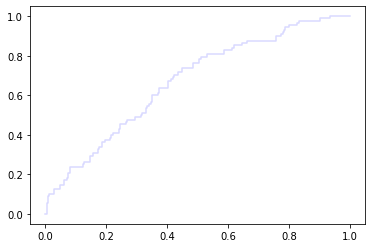

1
Num_samples: 432
acc:  0.8263888888888888
228 133 19 52
              precision    recall  f1-score   support

           0       0.92      0.63      0.75       361
           1       0.28      0.73      0.41        71

    accuracy                           0.65       432
   macro avg       0.60      0.68      0.58       432
weighted avg       0.82      0.65      0.69       432



/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/ipykernel_launcher.py:49: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


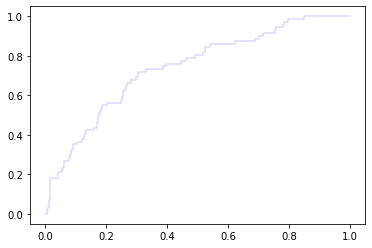

2
Num_samples: 432
acc:  0.7546296296296297
146 211 9 66
              precision    recall  f1-score   support

           0       0.94      0.41      0.57       357
           1       0.24      0.88      0.38        75

    accuracy                           0.49       432
   macro avg       0.59      0.64      0.47       432
weighted avg       0.82      0.49      0.54       432



/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/ipykernel_launcher.py:49: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


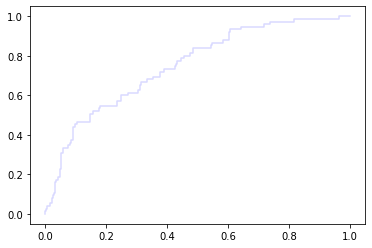

3
Num_samples: 432
acc:  0.8101851851851852
292 60 54 26
              precision    recall  f1-score   support

           0       0.84      0.83      0.84       352
           1       0.30      0.33      0.31        80

    accuracy                           0.74       432
   macro avg       0.57      0.58      0.57       432
weighted avg       0.74      0.74      0.74       432



/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/ipykernel_launcher.py:49: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


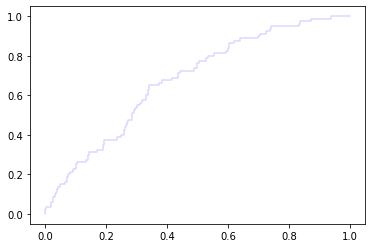

4
Num_samples: 432
acc:  0.7824074074074074
280 76 49 27
              precision    recall  f1-score   support

           0       0.85      0.79      0.82       356
           1       0.26      0.36      0.30        76

    accuracy                           0.71       432
   macro avg       0.56      0.57      0.56       432
weighted avg       0.75      0.71      0.73       432



/home/pmp/anaconda3/envs/COVID/lib/python3.7/site-packages/ipykernel_launcher.py:49: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


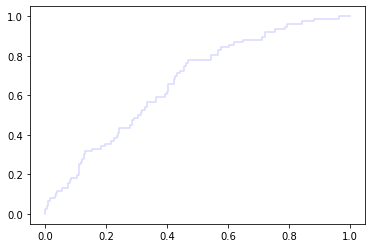

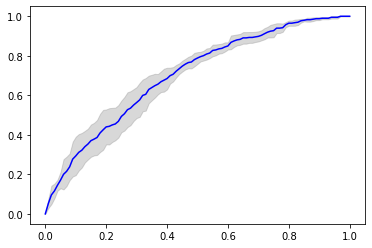

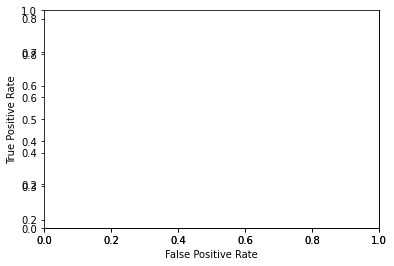

In [32]:
rt_sv_dir = '/home/pmp/Workspace/Myoungjin/CoughRecognition/virufy-covid-main/cough/model/'
# Calculate ROC curves for each run
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from scipy import interp
import sklearn

# EDIT MODEL PATHS TO USE
models = {0: rt_sv_dir+'0/020--0.609--0.278.hdf5',
          1: rt_sv_dir+'1/020--0.471--0.357.hdf5',
          2: rt_sv_dir+'2/020--0.546--0.304.hdf5',
          3: rt_sv_dir+'3/020--0.520--0.317.hdf5',
          4: rt_sv_dir+'4/020--0.567--0.235.hdf5'
          }

tprs = []
base_fpr = np.linspace(0, 1, 101)
for iii in range(5):
  print(iii)

  test_features= DATA[iii]['MFCCS'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_extra   = DATA[iii]['EXTRA'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_imgs    = DATA[iii]['MEL'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_labels  = DATA[iii]['LABELS'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  TEST          = TripleInputGenerator(test_features,test_imgs,test_extra,test_labels,batch_size=48,target_size=(64,64))
    
  model = keras.models.load_model(models[iii])
  y_score = model.predict(TEST)
  fpr, tpr, _ = roc_curve(test_labels[:len(y_score)], y_score)
  
  print('Num_samples:', len(y_score))
  print('acc: ', sklearn.metrics.accuracy_score(test_labels[:len(y_score)], y_score>0.5))
  y_pred = [] 
  for i in range(len(y_score)):
    if y_score[i] >= 0.1:
        y_pred.append(1)
    else:
        y_pred.append(0)
  #print(y_pred)
  
  tn, fp, fn, tp = confusion_matrix(test_labels[:len(y_score)], y_pred).ravel()
  print(tn,fp,fn,tp)
  #print("accuracy : ",(tp+tn)/(tp+tn+fp+fn),"sen: ",tp/(tp+fn), "spe: ",tn/(fp+tn))
  print(classification_report(test_labels[:len(y_score)],y_pred))

  plt.plot(fpr, tpr, 'b', alpha=0.15)
  tpr = interp(base_fpr, fpr, tpr)
  tpr[0] = 0.0
  tprs.append(tpr)
  plt.show()
  #print(tpr)
  #print(fpr)
##
tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

plt.plot(base_fpr,mean_tprs,'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)
plt.show()

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axes().set_aspect('equal', 'datalim')
#plt.savefig('roc_curve.png')
plt.show()